In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import xlwings as xw
import ipywidgets 

In [2]:
oblast = gpd.read_file("maps/ukraine_shape/ukr_admbnda_adm1_sspe_20220114.shp", crs='epsg:4326').to_crs(epsg=3857)
conflict = gpd.read_file("maps/conflict_map/conflict_map_shapefile.shp", crs='epsg:3857')
crop_mask = gpd.read_file("maps\WORLDCOVER\low_res_only_crop_vector.geojson", crs = 'epsg:3857').to_crs(epsg=3857).assign(DN = lambda df: df['DN'].replace(0, pd.NA))

C:\Users\amich\anaconda3\envs\ukraine_dash\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


<AxesSubplot:>

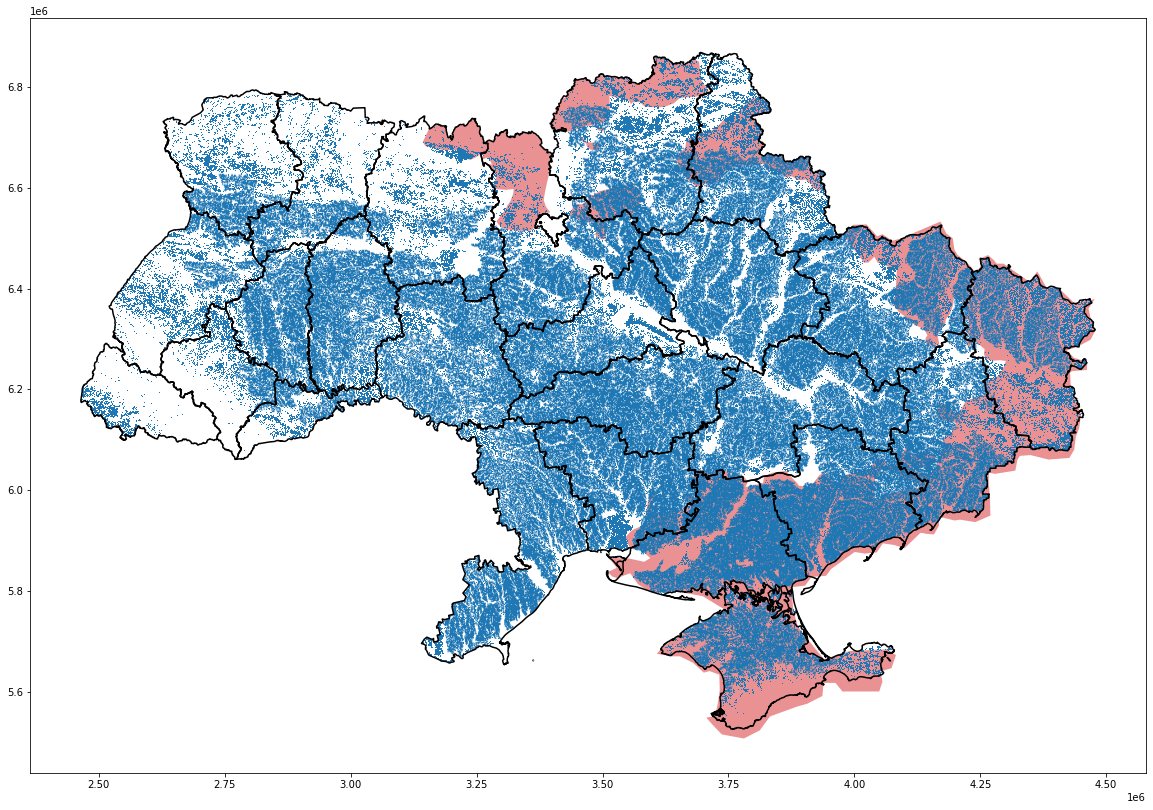

In [3]:
fig, ax = plt.subplots(figsize=(20,20))

oblast.boundary.plot(ax=ax, color='black')
conflict.plot(ax=ax, color='tab:red', alpha=.5)
crop_mask.plot('DN', ax=ax, categorical=True)

In [4]:
oblast_with_crop_mask = (
    oblast
    .to_crs({'proj':'cea', 'epsg' : 3857})
    .overlay(crop_mask.to_crs({'proj':'cea', 'epsg' : 3857}))
    .dropna(subset='DN')
    .assign(area = lambda df: df.geometry.area)
    .groupby('ADM1_EN')
    ['area'].sum()
    .to_frame()
    .rename({'area' : 'crop_area'}, axis=1)
    )

In [5]:
crop_mask_conflict = crop_mask.overlay(conflict).dropna()

In [6]:
all_merged = (
    oblast
    .to_crs({'proj':'cea'})
    .overlay(crop_mask_conflict.to_crs({'proj':'cea'}), how='intersection')
    .merge(oblast_with_crop_mask, left_on = ['ADM1_EN'], right_index=True)
    )

In [7]:
perc_affected = (
    all_merged
    .assign(area_crop_mask_conflict = lambda df: df.geometry.area)
    .groupby('ADM1_EN')
    [['crop_area', 'area_crop_mask_conflict']]
    .agg(crop_area = ('crop_area', 'first'), area_crop_mask_conflict = ('area_crop_mask_conflict', 'sum'))
    .apply(lambda x: x['area_crop_mask_conflict']/x['crop_area'], axis=1)
)

In [8]:
perc_affected

ADM1_EN
Avtonomna Respublika Krym    0.987069
Chernihivska                 0.306939
Dnipropetrovska              0.008987
Donetska                     0.542372
Kharkivska                   0.367148
Khersonska                   0.995345
Kyivska                      0.127230
Luhanska                     0.966454
Mykolaivska                  0.111695
Sumska                       0.331118
Zaporizka                    0.720130
Zhytomyrska                  0.035061
dtype: float64

In [9]:
oblast_with_perc_affected = (
    oblast
    .merge(perc_affected.to_frame(), left_on = ['ADM1_EN'], right_index=True, how='left')
    .rename({0 : 'perc_affected'}, axis=1)
)

## Input Data into Workbook with `xlwings`    

In [10]:
wb = xw.Book("excel\crop_impact_estimator.xlsx")

sheet = wb.sheets['Input Sheet']

In [11]:
from IPython.display import display, clear_output

def map_create():

    m = conflict.explore(color='red', width="100%", height="100%")

    oblast_with_perc_affected.explore(m=m, tooltip = ['perc_affected'])
    # crop_mask.dropna(subset='DN').explore('DN', m=m) # This really slows down the map. Might need to lower resolution

    return display(m)

def table_create(**kwargs):
    # Send results to workbook

    for i, sheet_oblast in zip(range(4,28), sheet.range("A4:A27").value):
        try:
            if kwargs.get(sheet_oblast)==0:
                sheet.range(f"B{i}").value = perc_affected.loc[sheet_oblast]
            else:
                sheet.range(f"B{i}").value = kwargs.get(sheet_oblast)
        except KeyError:
            sheet.range(f"B{i}").value = 0


    # get results table
    baseline_table_2021 = sheet.range("E16:F21").value 
    baseline_table_2020 = sheet.range("E23:F28").value 

    baseline_2021_df = pd.DataFrame(baseline_table_2021[1:], columns = baseline_table_2021[0]).rename({None : ''}, axis=1).set_index('Est. Impacted share (2021 baseline)')
    baseline_2020_df = pd.DataFrame(baseline_table_2020[1:], columns = baseline_table_2020[0]).rename({None : ''}, axis=1).set_index('Est. Impacted share (2020 baseline)')

    display(baseline_2020_df)
    display(baseline_2021_df)
    display(perc_affected.to_frame().rename({0 : '', 'ADM1_EN' : 'Oblast'}, axis=1))

    
text_widgets = {k: ipywidgets.FloatText(value=perc_affected.loc[k] if k in perc_affected.index.unique() else 0, step=.1, description=k) for k in oblast.ADM1_EN.unique()}

text_box = ipywidgets.Accordion((ipywidgets.HBox(list(text_widgets.values())), ))

text_box.set_title(0, "Oblast Percentage Affected")
text_box.selected_index = None

out_table = ipywidgets.interactive_output(table_create, text_widgets)
out_map = ipywidgets.interactive(map_create)

tab = ipywidgets.Tab()

children = [out_table, out_map]

tab.children = children
tab.set_title(0, 'Estimated Impacts')
tab.set_title(1, 'Map')

ui = ipywidgets.VBox([text_box, tab])

display(ui)
